# Introduction

The decision tree classifier is a popular machine learning algorithm used for classification and regression problems. It is a tree-based model that partitions the feature space into a set of non-overlapping regions and predicts the target value for each region. In this lab, we will learn how to analyse the decision tree structure to gain further insight into the relation between the features and the target to predict.

# Train a Decision Tree Classifier

First, we need to fit a decision tree classifier using the **load_iris** dataset from scikit-learn. This dataset contains 3 classes of 50 instances each, where each class refers to a type of iris plant. We will split the dataset into training and test sets and fit a decision tree classifier with a maximum of 3 leaf nodes.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = DecisionTreeClassifier(max_leaf_nodes=3, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=3, random_state=42)

# Analyze the Binary Tree Structure

The decision tree classifier has an attribute called **tree_** which allows access to low level attributes such as **node_count**, the total number of nodes, and **max_depth**, the maximal depth of the tree. It also stores the entire binary tree structure, represented as a number of parallel arrays. Using these arrays, we can traverse the tree structure to compute various properties such as the depth of each node and whether or not it is a leaf. Below is the code to compute these properties:

In [2]:
import numpy as np

n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 5 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 2] <= 2.449999988079071 else to node 2.
	node=1 is a leaf node.
	node=2 is a split node: go to node 3 if X[:, 2] <= 4.75 else to node 4.
		node=3 is a leaf node.
		node=4 is a leaf node.


# Visualize the Decision Tree

We can also visualize the decision tree using the **plot_tree** function from scikit-learn's **tree** module.

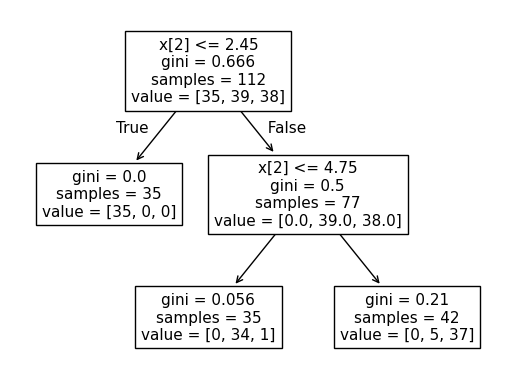

In [3]:
from sklearn import tree
import matplotlib.pyplot as plt

tree.plot_tree(clf)
plt.show()

# Retrieve Decision Path and Leaf Nodes

We can retrieve the decision path of samples of interest using the **decision_path** method. This method outputs an indicator matrix that allows us to retrieve the nodes the samples of interest traverse through. The leaf ids reached by samples of interest can be obtained with the **apply** method. This returns an array of the node ids of the leaves reached by each sample of interest. Using the leaf ids and the **decision_path** we can obtain the splitting conditions that were used to predict a sample or a group of samples. Below is the code to retrieve the decision path and leaf nodes for one sample:

In [4]:
node_indicator = clf.decision_path(X_test)
leaf_id = clf.apply(X_test)

sample_id = 0
# obtain ids of the nodes `sample_id` goes through, i.e., row `sample_id`
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] : node_indicator.indptr[sample_id + 1]
]

print("Rules used to predict sample {id}:\n".format(id=sample_id))
for node_id in node_index:
    # continue to the next node if it is a leaf node
    if leaf_id[sample_id] == node_id:
        continue

    # check if value of the split feature for sample 0 is below threshold
    if X_test[sample_id, feature[node_id]] <= threshold[node_id]:
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print(
        "decision node {node} : (X_test[{sample}, {feature}] = {value}) "
        "{inequality} {threshold})".format(
            node=node_id,
            sample=sample_id,
            feature=feature[node_id],
            value=X_test[sample_id, feature[node_id]],
            inequality=threshold_sign,
            threshold=threshold[node_id],
        )
    )

Rules used to predict sample 0:

decision node 0 : (X_test[0, 2] = 4.7) > 2.449999988079071)
decision node 2 : (X_test[0, 2] = 4.7) <= 4.75)


# Determine Common Nodes for a Group of Samples

For a group of samples, we can determine the common nodes the samples go through using the **decision_path** method and the **toarray** method to convert the indicator matrix to a dense array.

In [5]:
sample_ids = [0, 1]
# boolean array indicating the nodes both samples go through
common_nodes = node_indicator.toarray()[sample_ids].sum(axis=0) == len(sample_ids)
# obtain node ids using position in array
common_node_id = np.arange(n_nodes)[common_nodes]

print(
    "\nThe following samples {samples} share the node(s) {nodes} in the tree.".format(
        samples=sample_ids, nodes=common_node_id
    )
)
print("This is {prop}% of all nodes.".format(prop=100 * len(common_node_id) / n_nodes))


The following samples [0, 1] share the node(s) [0] in the tree.
This is 20.0% of all nodes.


# Summary

In this lab, we have learned how to analyse the decision tree structure to gain further insight into the relation between the features and the target to predict. We have seen how to retrieve the binary tree structure, visualize the decision tree, and retrieve the decision path and leaf nodes for a sample or a group of samples. These techniques can help us better understand how the decision tree classifier makes its predictions and can guide us in fine-tuning the model to improve its performance.